### 1. Скачайте датасет fifаs2.сsv. Проанализируйте его и определите, какие данные являются неполными. Удалите ненужные колонки и недостающие значения.

In [168]:
import pandas as pd
df = pd.read_csv('fifa_s2.csv')

Посмотрим на размер датасета, типы данных и чем он заполнен.

In [169]:
df.shape


(2399, 18)

In [170]:
df.dtypes

ID                            int64
Name                         object
Age                           int64
Nationality                  object
Overall                       int64
Potential                     int64
Club                         object
Value                       float64
Wage                          int64
Preferred Foot               object
International Reputation    float64
Skill Moves                 float64
Position                     object
Joined                        int64
Contract Valid Until         object
Height                      float64
Weight                      float64
Release Clause              float64
dtype: object

In [171]:
df.head

<bound method NDFrame.head of           ID           Name  Age  Nationality  Overall  Potential  \
0       1179      G. Buffon   40        Italy       88         88   
1       5479       Casillas   37        Spain       82         82   
2       8205          Braga   35     Portugal       70         70   
3       9014      A. Robben   34  Netherlands       84         84   
4      19521      J. Ibehre   35      England       61         61   
...      ...            ...  ...          ...      ...        ...   
2394  246465       Guerrero   16        Spain       63         76   
2395  246594    H. Massengo   16       France       62         75   
2396  246599  Guillem Jaime   19        Spain       64         80   
2397  246606    Fran García   18        Spain       64         79   
2398  246608        Fidalgo   21        Spain       65         75   

                     Club    Value  Wage Preferred Foot  \
0     Paris Saint-Germain   4000.0    77          Right   
1                FC Por

В датасете 2399 строк и 18 колонок. Типы данных соответствуют содержимому колонок. Посмотрим полные ли данные:

<AxesSubplot:>

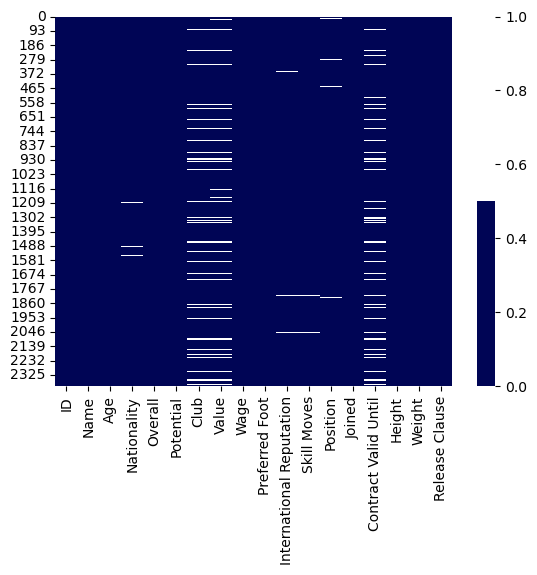

In [172]:
import seaborn as sns
cols = df.columns[:100]
colors = ['#000555', '#FFFFFF']
sns.heatmap(df[cols].isnull(), cmap = sns.color_palette(colors))

In [173]:
import numpy as np
for col in df.columns:
    missing_values = np.mean(df[col].isnull())
    print('{} - {}%'.format(col,round(missing_values*100, 2)))

ID - 0.0%
Name - 0.0%
Age - 0.0%
Nationality - 0.29%
Overall - 0.0%
Potential - 0.0%
Club - 10.05%
Value - 10.71%
Wage - 0.0%
Preferred Foot - 0.0%
International Reputation - 0.42%
Skill Moves - 0.25%
Position - 0.88%
Joined - 0.0%
Contract Valid Until - 11.38%
Height - 0.0%
Weight - 0.0%
Release Clause - 0.13%


Много пропусков в столбцах Club, Value и Contract Valid Until. Очевидно, что спортсмены без текущей принадлежности к клубу не имеют цены выкупа и даты конца контракта. Для начала заполним пустые ячейки в столбце 'Club' на значение 'Free agent'.

In [174]:
df['Club'] = df['Club'].fillna('Free agent')

Теперь заполним значением '0' цену выкупа контракта спортсменов, у которых нет контракта.

In [175]:
def fill_with_zeros(df):
    df.loc[df['Club'] == 'Free agent', 'Value'] = 0
    return df

In [176]:
df = fill_with_zeros(df)

И похожей функцией заполним зату окончания контракта значением 'No contract'

In [177]:
def fill_contract(df):
    df.loc[df['Club'] == 'Free agent', 'Contract Valid Until'] = 'No contract'
    return df

In [178]:
df = fill_contract(df)

Есть небольшие пропуски данных в столбцах 'Nationality', 'International Reputation', 'Skill Moves', 'Position' и 'Release Clause'. Я не могу заполнить эти данные ничем, кроме заглушек, потому что это в основном качественные, а не числовые значения. Но речь идет о десятых долях процента, поэтому я бы оставил как есть. Если бы все же заполнял, то таким образом:

In [179]:
df['Nationality'] = df['Nationality'].fillna('No data')

### 2. Найдите в датафрейме полные дубликаты и удалите их. Значения могут быть одинаковыми, но написаны по-разному. Например, может отличаться размер регистра (заглавные и строчные буквы). Особое внимание уделить колонке с названиями команд.

Для начала посмотрим что не так с колонкой названия команд:

In [180]:
teams_display = df['Club'].value_counts()
print(teams_display)

Free agent            241
Manchester City        33
Arsenal                33
CD Leganés             33
Cardiff City           33
                     ... 
Fc Barcelona            2
Livingston FC           1
FC Heidenheim 1846      1
Aalborg BK              1
FC Köln                 1
Name: Club, Length: 82, dtype: int64


Дело похоже в том, что некоторые названия клубов написаны в разных регистрах. Приведем все к нижнему регистру:

In [181]:
df = df.applymap(lambda x: x.lower() if type(x) == str else x)

Не вполне помогло, убрали только дубликат FC Barcelona. Проблема скорее всего в пробелах. Применим метод strip для удаления пробелов в начале и конце значения:

In [182]:
df['Club'] = df['Club'].str.strip()

_Не могу понять почему не работает, даже все пробелы менял на пустое значение, все равно FC Köln и FC Heidenheim 1846 Pandas считает уникальными_

Найдем дубликаты:

In [183]:
duplicates = df[df.duplicated()]
print(duplicates)

         ID        Name  Age Nationality  Overall  Potential          Club  \
154  168651  i. rakitić   30     croatia       87         87  fc barcelona   
304  181872    a. vidal   31       chile       85         85  fc barcelona   

       Value  Wage Preferred Foot  International Reputation  Skill Moves  \
154  46500.0   260          right                       4.0          3.0   
304  26000.0   205          right                       4.0          3.0   

    Position  Joined Contract Valid Until    Height  Weight  Release Clause  
154      rcm    2014           01/01/2021  6.000000   172.0         95300.0  
304      cam    2018           01/01/2021  5.916667   165.0         53300.0  


Что интересно, без приведения в нижний регистр дубликаты не находились.

Удалим дубликаты:

In [184]:
df.drop_duplicates()

,ID,Name,Age,Nationality,Overall,Potential,Club,Value,Wage,Preferred Foot,International Reputation,Skill Moves,Position,Joined,Contract Valid Until,Height,Weight,Release Clause
0,1179,g. buffon,40,italy,88,88,paris saint-germain,4000.0,77,right,4.0,1.0,gk,2018,01/01/2019,6.333333,203.0,7400.0
1,5479,casillas,37,spain,82,82,fc porto,1500.0,10,left,4.0,1.0,NaN,2015,01/01/2019,6.083333,185.0,3000.0
2,8205,braga,35,portugal,70,70,cd aves,750.0,5,right,1.0,3.0,lcm,2017,01/01/2019,5.916667,165.0,1600.0
3,9014,a. robben,34,netherlands,84,84,fc bayern münchen,15500.0,110,left,4.0,4.0,rm,2009,01/01/2019,5.916667,176.0,25600.0
4,19521,j. ibehre,35,england,61,61,cambridge united,120.0,2,right,1.0,2.0,st,2017,01/01/2019,6.333333,203.0,210.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2394,246465,guerrero,16,spain,63,76,cf rayo majadahonda,625.0,1,left,1.0,3.0,cm,2018,01/01/2019,5.916667,165.0,1400.0
2395,246594,h. massengo,16,france,62,75,as monaco,450.0,2,right,1.0,2.0,cdm,2018,01/01/2021,5.833333,146.0,1100.0
2396,246599,guillem jaime,19,spain,64,80,fc barcelona,975.0,13,right,1.0,3.0,rw,2018,01/01/2020,5.833333,154.0,2600.0
2397,246606,fran garcía,18,spain,64,79,real madrid,825.0,9,left,1.0,2.0,lb,2018,01/01/2019,5.583333,139.0,2200.0


### 3. Напишите функцию, которая добавит колонку с разбиением возраста по группам: до 20, от 20 до 30, от 30 до 36 и старше 36. Посчитайте количество футболистов в каждой категории.

In [185]:
def group_by_age(Age):
    if Age < 20:
        return '<20'
    elif 20 <= Age < 30:
        return '20-30'
    elif 30 <= Age < 36:
        return '30-36'
    else:
        return '36+'

df['group_by_age'] = df['Age'].apply(group_by_age)

In [186]:
counts = df['group_by_age'].value_counts()
print(counts)

20-30    1646
30-36     460
<20       270
36+        23
Name: group_by_age, dtype: int64
